# **Assignment: Phase Diagram and Out-of-Equilibrium Dynamics**

#### **Author:** Guillermo Abad López

#### **Date:** 17 Feb, 2025
---

## **I. Introduction**
#### **We will study the phase diagram and the out-of-equilibrium dynamics of a paradigmatic spin model. The model is defined on an open chain of spin-1/2 constituents of length $L$. The Hamiltonian is given by [1]:**

#### $$H(p,\lambda)=-\sum_{i}\left[\sigma^{z}_{i}\sigma^{z}_{i+1}+\lambda\sigma^{z}_{i}+p \left(\sigma^{z}_{i}\sigma^{z}_{i+2}+\lambda\sigma^{x}_{i}\sigma^{x}_{i+1}\right)\right].$$

#### **Key properties of the Hamiltonian:**

1. **If $p=0$, the model reduces to the standard transverse-field Ising model.**

2. **If $\lambda=1$ and $p\to\infty$, the Ising part becomes negligible, and the model is more complicated.**

3. **For $p\neq 0$, the Hamiltonian includes next-nearest-neighbor interactions.**


#### **The goal of this assignment is to analyze the phase diagram of the model in the $(p, \lambda)$ plane and to study its out-of-equilibrium dynamics. We will focus on values $p \leq 1$ to stay close to the transverse field Ising model (whose properties you can obtain by setting p = 0).**


----


## **II. Phase Diagram (5 points)**
#### **Using $TeMPy$ [2, 3], perform the following tasks:**

### 1. **Define the model in $TeMPy$** (2 points).

 In the code below, we define a new model class (here called `ExtendedIsingModel`) that extends Tenpy’s `SpinChainNNN`.

In [387]:
# ruff: noqa: RUF002, RUF003, T201, CPY001

import itertools
import warnings
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tenpy.algorithms import ExpMPOEvolution, TwoSiteDMRGEngine  # Old TEBDEngine
from tenpy.models.spins_nnn import SpinChainNNN2
from tenpy.networks.mps import MPS
from tenpy.simulations import RealTimeEvolution

warnings.filterwarnings("ignore", message="unused option", category=UserWarning)


####################################################################################################
################## MAIN Model and ansatz class, with algorithm implemented in it ###################
####################################################################################################


class ExtendedIsingModel(SpinChainNNN2):
    def __init__(self, model_params: dict | None = None):
        """Initialize the extended Ising model.

        The Hamiltonian is given by
            H = -∑ₙ [ σᶻₙ σᶻₙ₊₁ + λ σᶻₙ + p (σᶻₙ σᶻₙ₊₂ + λ σˣₙ σˣₙ₊₁) ].

        Parameters
        ----------
            model_params (dict): A dictionary containing the model parameters. The following keys are recognized:
                L (int):  Number of Grouped sites (`site.GroupedSite`), at each unit cell. i.e. There will be 2*L total sites. Defaults to 2.
                S (float): The 2S+1 local states range from m = -S, -S+1, ... +S, can take values: {0.5, 1, 1.5, 2, ...}. Defaults to 0.5.
                p (float): The next-nearest neighbor strength for sigma_z and close neighbor sigma_x interactions; p=0 gives the transverse field Ising model. Defaults to 0.0.
                lmbd (float): The field strength of Z, affecting also the close neighbor sigma_x interactions. Defaults to 1.0.
                bc_MPS (str): The boundary conditions for the MPS simulation. Defaults to "infinite".
                conserve (str | None): What should be conserved:  'best' | 'Sz' | 'parity' | None. Defaults to None.
        """
        # Set default parameters (Transverse field Ising model):
        defaults = {
            "L": 2,
            "S": 0.5,
            "p": 0.0,
            "lmbd": 1.0,
            "bc_MPS": "infinite",
            "conserve": None,
        }
        # Update default parameters with any provided ones:
        if model_params is not None:
            defaults |= model_params

        # Store the parameters as attributes.
        self.L: int = defaults["L"]
        """ int: Number of sites (`site.GroupedSite`), at each unit cell. Defaults to 2. """

        self.S: float = defaults["S"]
        """ float: The 2S+1 local states range from m = -S, -S+1, ... +S, can take values: {0.5, 1, 1.5, 2, ...}. Defaults to 0.5."""

        self.p: float = defaults["p"]
        """ float: The next-nearest neighbor strength for sigma_z and close neighbor sigma_x interactions; p=0 gives the transverse field Ising model. Defaults to 0.0. """

        self.lmbd: float = defaults["lmbd"]
        """ float: The field strength of Z, affecting also the close neighbor sigma_x interactions. Defaults to 1.0. """

        self.bc_MPS: str = defaults["bc_MPS"]
        """ str: The boundary conditions for the MPS simulation. Defaults to "infinite". """

        self.conserve: str | None = defaults["conserve"]
        """What should be conserved:  'best' | 'Sz' | 'parity' | None. Defaults to None."""

        # Initialize the model via the parent constructor.
        super().__init__(self.spin_chain_params)

    @property
    def spin_chain_params(self) -> dict:
        """Translate the class parameters to the SpinChainNNN model.
        The factor 2, is because SpinChainNNN uses 0.5 * pauli_i, while we use pauli_i.

        Returns
        -------
            dict: The parameters for the SpinChainNNN model.
        """
        return {
            "L": self.L,  # Number of Grouped sites,i.e. There will be 2*L total sites.
            "S": self.S,
            "Jx": -self.p * self.lmbd * 4,  # Close neighbor sigma_x interaction.
            "Jy": 0,
            "Jz": -4,  # Close neighbor sigma_z interaction.
            "hx": self.lmbd * 2,  # Transverse (sigma_z) field strength.
            "hy": 0,
            "hz": 0,
            "Jxp": 0,
            "Jyp": 0,
            "Jzp": -self.p * 4,  # Next-nearest neighbor sigma_z interaction.
            "bc_MPS": self.bc_MPS,
            "conserve": self.conserve,
        }

    def get_plus_ansatz(self, init_state: str) -> MPS:
        """Get an |++...++> ansatz for the ground state of the model.

        Parameters
        ----------
            init_state (str): The initial state to use for the ansatz. Can be "++" or "up".

        Returns
        -------
            MPS: An MPS representing the ansatz for the ground state.
        """
        # Define the |++> state, for each GroupedSite (Site*2):
        if init_state == "plus":
            init_state = np.array([1, 1]) / np.sqrt(2)
        else:
            init_state = np.array([1, 0])

        # Create the MPS for mulitple sites:
        ansatz = MPS.from_product_state(
            self.lat.mps_sites(),  # Same lattice than the model.
            [init_state] * self.L,  # State plus repeated N_sites times; |++..(2L)..++>
            bc=self.bc_MPS,
        )

        # Normalize the state and put in canonical form:
        ansatz.canonical_form()

        return ansatz

    def run_dmrg(self, state: MPS, chi: int = 32, max_sweeps: int = 10) -> tuple[float, MPS]:
        """Runs the DMRG algorithm on a state.

        Parameters
        ----------
            state (MPS): The initial state to optimize.
            chi (int): The bond dimension of the MPS. Defaults to 32.
            max_sweeps (int): The maximum number of DMRG sweeps. Defaults to 10.

        Returns
        -------
            E (float): The energy of the resulting ground state MPS.
            state (MPS): The MPS representing the ground state after the simulation.
        """
        dmrg_params = {
            "mixer": None,  # setting this to True helps to escape local minima
            "max_E_err": 1.0e-10,
            # "chi_list": {0: chi},  # Use a constant bond dimension chi.
            # "energy_convergence": 1.0e-10,  # Stop if energy is below this value.
            "max_sweeps": max_sweeps,
            "trunc_params": {
                "chi_max": chi,
                # "svd_min": 1.0e-10,
            },
            # "verbose": True,
            # "combine": True,
        }
        return TwoSiteDMRGEngine(state, self, dmrg_params).run()  # E, state

    def run_time_evolution(self, state: MPS) -> dict:
        """Runs time evolution of the state under the Hamiltonian.

        Parameters
        ----------
            state (MPS): The initial state to evolve.

        Returns
        -------
            dict: The results as returned by prepare_results_for_save.
        """
        MPO_evol_params = {
            "dt": 0.1,
            "order": 4,
            "trunc_params": {
                "chi_max": 100,
                "svd_min": 1.0e-10,
            },
            "verbose": True,
        }
        return RealTimeEvolution(ExpMPOEvolution(state, self, MPO_evol_params)).run()


####################################################################################################
######### Sweeper class to sweep and plot Algorithms for a range of D, p and lambda values #########
####################################################################################################


class ExtendedIsingModelSweeper:
    @staticmethod
    def sweep_dmrg(
        Ds: list[int], p_values: Iterable[float], lmbd_values: Iterable[float], init_state: str = "up"
    ) -> tuple[dict[tuple[int, float, float], float], ...]:
        """Run DMRG for a range of bond dimensions D, p and lambda values.

        Parameters
        ----------
            Ds (list[int]): List of bond dimensions to sweep.
            p_values (Iterable[float]): List of p values to sweep.
            lmbd_values (Iterable[float]): List of lambda values to sweep.
            init_state (str): The initial state to use. Defaults to "up".

        Returns
        -------
            results_E (dict[tuple[int, float, float], float]): Dictionary containing the energy for each p, lambda and D.
            results_xi (dict[tuple[int, float, float], float]): Dictionary containing the correlation length xi for each p, lambda and D.
            results_S (dict[tuple[int, float, float], float]): Dictionary containing the entropy S for each p, lambda and D.
        """
        # dictionary to store E, xi, and S for each p, lambda and D
        results_xi, results_E, results_S = {}, {}, {}

        for p, lmbd, D in itertools.product(p_values, lmbd_values, Ds):
            results_xi[p, lmbd, D] = {}
            results_E[p, lmbd, D] = {}
            results_S[p, lmbd, D] = {}

            model_params = {"L": 2, "S": 0.5, "p": p, "lmbd": lmbd, "bc_MPS": "infinite", "conserve": None}
            model = ExtendedIsingModel(model_params)

            # Get an initial ansatz for the model:
            state = model.get_plus_ansatz(init_state)

            # Run the iMPS simulation using e.g. iDMRG with bond dimension D
            E, state = model.run_dmrg(state=state, chi=D)
            results_E[p, lmbd, D] = E

            # Compute correlation length xi
            xi = state.correlation_length()
            results_xi[p, lmbd, D] = xi

            # Compute entropy
            S = ExtendedIsingModelSweeper.compute_halfchain_entropy(state)
            results_S[p, lmbd, D] = S

        return results_E, results_xi, results_S

    @staticmethod
    def compute_halfchain_entropy(state: MPS) -> float:
        """Compute the half-chain entropy of the state.

        Parameters
        ----------
            state (MPS): The state for which to compute the entropy.

        Returns
        -------
            float: The half-chain entropy of the state.
        """
        # state.entanglement_entropy() returns a list of S for each bond; take the central one
        S_vals = state.entanglement_entropy()
        return S_vals[len(S_vals) // 2]

    @staticmethod
    def get_results_vs_p_and_lambda(
        D: int, results: dict, p_values: Iterable[float], lmbd_values: Iterable[float]
    ) -> np.ndarray:
        """Create a 2D plot of the energy as a function of p and lambda.

        Parameters
        ----------
            D (int): The bond dimension to plot.
            results (dict): Dictionary containing the energy or correlations for each p, lambda and D.
            p_values (Iterable[float]): List of p values to sweep.
            lmbd_values (Iterable[float]): List of lambda values to sweep.

        Returns
        -------
            np.ndarray: The new results structure as a function of p and lambda.
        """
        if len(p_values) == 1:
            R = np.zeros(len(lmbd_values))
            for j, lmbd in enumerate(lmbd_values):
                R[j] = results[p_values[0], lmbd, D]
        else:
            R = np.zeros((len(p_values), len(lmbd_values)))
            for i, p in enumerate(p_values):
                for j, lmbd in enumerate(lmbd_values):
                    R[i, j] = results[p, lmbd, D]

        return R

    @staticmethod
    def get_results_vs_D(Ds: Iterable[int], results: dict, p: float, lmbd: float) -> np.ndarray:
        """Create a 2D plot of the energy as a function of p and lambda.

        Parameters
        ----------
            Ds (Iterable[int]): The bond dimensions to plot.
            results (dict): Dictionary containing the energy or correlations for each p, lambda and D.
            p (float): p to plot.
            lmbd (float): Lambda to plot.

        Returns
        -------
            np.ndarray: The new results structure as a function of p and lambda.
        """
        R = np.zeros(len(Ds))
        for j, D in enumerate(Ds):
            R[j] = results[p, lmbd, D]
        return R

    @staticmethod
    def plot_sweep_vs_p_and_lambda(
        results: dict,
        title: str,
        zlabel: str,
        Ds: list[int],
        p_values: Iterable[float],
        lmbd_values: Iterable[float],
        color: str = "plasma",
    ) -> None:
        """Plot the results of the sweep as a function of p and lambda.

        Parameters
        ----------
            results (dict): Dictionary containing the energy or correlations for each p, lambda and D.
            title (str): The title of the plot.
            zlabel (str): The label of the z-axis.
            Ds (list[int]): List of bond dimensions to sweep.
            p_values (Iterable[float]): List of p values to sweep.
            lmbd_values (Iterable[float]): List of lambda values to sweep.
        """
        # Post-process results to identify saturation vs. growth of xi.
        fig = plt.figure(figsize=(16, 12))
        ax = [fig.add_subplot(max(len(Ds) // 2, 1), 3, i, projection="3d") for i in range(1, len(Ds) + 1)]

        for i, D in enumerate(Ds):
            # Values to plot
            R = ExtendedIsingModelSweeper.get_results_vs_p_and_lambda(D, results, p_values, lmbd_values)
            L, P = np.meshgrid(lmbd_values, p_values)

            ax[i].plot_surface(L, P, R, cmap=color)
            ax[i].set_title(f"{title} vs lambda and p, for D = {D!s}")
            ax[i].set_xlabel("lambda")
            ax[i].set_ylabel("p")
            ax[i].set_zlabel(zlabel)
            # ax[i].view_init(15, -60)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_cut_at_fixed_p_vs_lambda(
        results: dict,
        title: str,
        ylabel: str,
        Ds: list[int],
        p: float,
        lmbd_values: Iterable[float],
        init_state: str,
        color: str = "plasma",
    ) -> None:
        """Plot the results of the sweep as a function of p and lambda.

        Parameters
        ----------
            results (dict): Dictionary containing the energy or correlations for each p, lambda and D.
            title (str): The title of the plot.
            ylabel (str): The label of the y-axis.
            Ds (list[int]): List of bond dimensions to sweep.
            p (float): Fixed p value to plot.
            lmbd_values (Iterable[float]): List of lambda values to sweep.
        """
        # Post-process results to identify saturation vs. growth of xi.
        plasma = cm._colormaps[color](np.linspace(0, 0.85, len(Ds)))

        for i, D in enumerate(Ds):
            # Values to plot
            R = ExtendedIsingModelSweeper.get_results_vs_p_and_lambda(D, results, [p], lmbd_values)

            plt.plot(lmbd_values, R, label=f"D = {D!s}", marker="o", linestyle="-", color=plasma[i])
            plt.title(f"{title} vs lambda, for p = {p} and init_state = {init_state}")
            plt.xlabel("lambda")
            plt.ylabel(ylabel)
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_vs_D_at_fixed_p_and_lambdas(
        results: dict,
        title: str,
        ylabel: str,
        Ds: list[int],
        p: float,
        lmbd_values: Iterable[float],
        init_state: str,
        color: str = "plasma",
    ) -> None:
        """Plot the results of the sweep as a function of p and lambda.

        Parameters
        ----------
            results (dict): Dictionary containing the energy or correlations for each p, lambda and D.
            title (str): The title of the plot.
            ylabel (str): The label of the y-axis.
            Ds (list[int]): List of bond dimensions to sweep.
            p (float): Fixed p value to plot.
            lmbd_values (Iterable[float]): List of lambda values to sweep.
        """
        # Post-process results to identify saturation vs. growth of xi.
        plasma = cm._colormaps[color](np.linspace(0, 0.85, len(lmbd_values)))

        for i, lmbd in enumerate(lmbd_values):
            # Values to plot
            R = ExtendedIsingModelSweeper.get_results_vs_D(Ds, results, p, lmbd)

            plt.plot(Ds, R, label=f"lambda = {lmbd:.5f}", marker="o", linestyle="-", color=plasma[i])
            plt.title(f"{title}, for p = {p} and init_state = {init_state}")
            plt.xlabel("D")
            plt.ylabel(ylabel)
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()


**Lattice & Sites:**

We create a one-dimensional chain of length L, where each site is a spin‑1/2 Hilbert space.

**Hamiltonian Terms:**
- The nearest-neighbor ZZ coupling is added for every adjacent pair 
$(i, i+1)$ with a coefficient $−1$. 
- The onsite field is implemented by adding $− \lambda$ times $\sigma^z$ on every site.
- The next-nearest-neighbor ZZ coupling couples sites $i$ and $i+2$ with strength $−p$.
- The XX coupling (with strength $−p\lambda$) is added between sites $i$ and $i+1$.

**Parameter Choices:**

The model parameters are provided via a dictionary. With default values being:

- `L (int)`:  Length of the chain in terms of `site.GroupedSite`, i.e. we have ``2*L`` spin sites. Defaults to 10.

- `S (float)`: The 2S+1 local states range from m = -S, -S+1, ... +S, can take values: {0.5, 1, 1.5, 2, ...}. Defaults to 0.5.

- `p (float)`: The next-nearest neighbor strength for sigma_z and close neighbor sigma_x interactions; p=0 gives the transverse field Ising model. Defaults to 0.0.

- `lmbd (float)`: The field strength of Z, affecting also the close neighbor sigma_x interactions. Defaults to 1.0.

- `bc_MPS (str)`: The boundary conditions for the MPS simulation. Defaults to "infinite".

- `conserve (str | None)`: What should be conserved:  'best' | 'Sz' | 'parity' | None. Defaults to None.

### 2. **Characterize the phase diagram using an infinite MPS ansatz** (2 points):

#### **(a) For each $(p,\lambda)$ point, run simulations with bond dimensions $D=16$ and $D=32$.**


#### Executions:
---

In the cells below we execute several `dmrg`'s to find the ground state of the system, which will be used for the posterior plots.

(In some cases I might advance some info asked later, like `D=64`, since the simus are the same)

In [ ]:
# Example of executing a sweep with this Sweep Class:
Ds = [2, 4, 8, 16, 32, 64]
p_values = np.linspace(0, 2, 10)
lmbd_values = np.linspace(0, 2, 20)

results_E3, results_xi3, results_S3 = ExtendedIsingModelSweeper.sweep_dmrg(
    Ds=Ds, p_values=p_values, lmbd_values=lmbd_values, init_state="up"
)

#### Post-process results to vizualize `Energy` vs `p` and `lambda`
---

#### `P` and `lambda` from 0->2, with `D=2,4,8,16,32,64`:

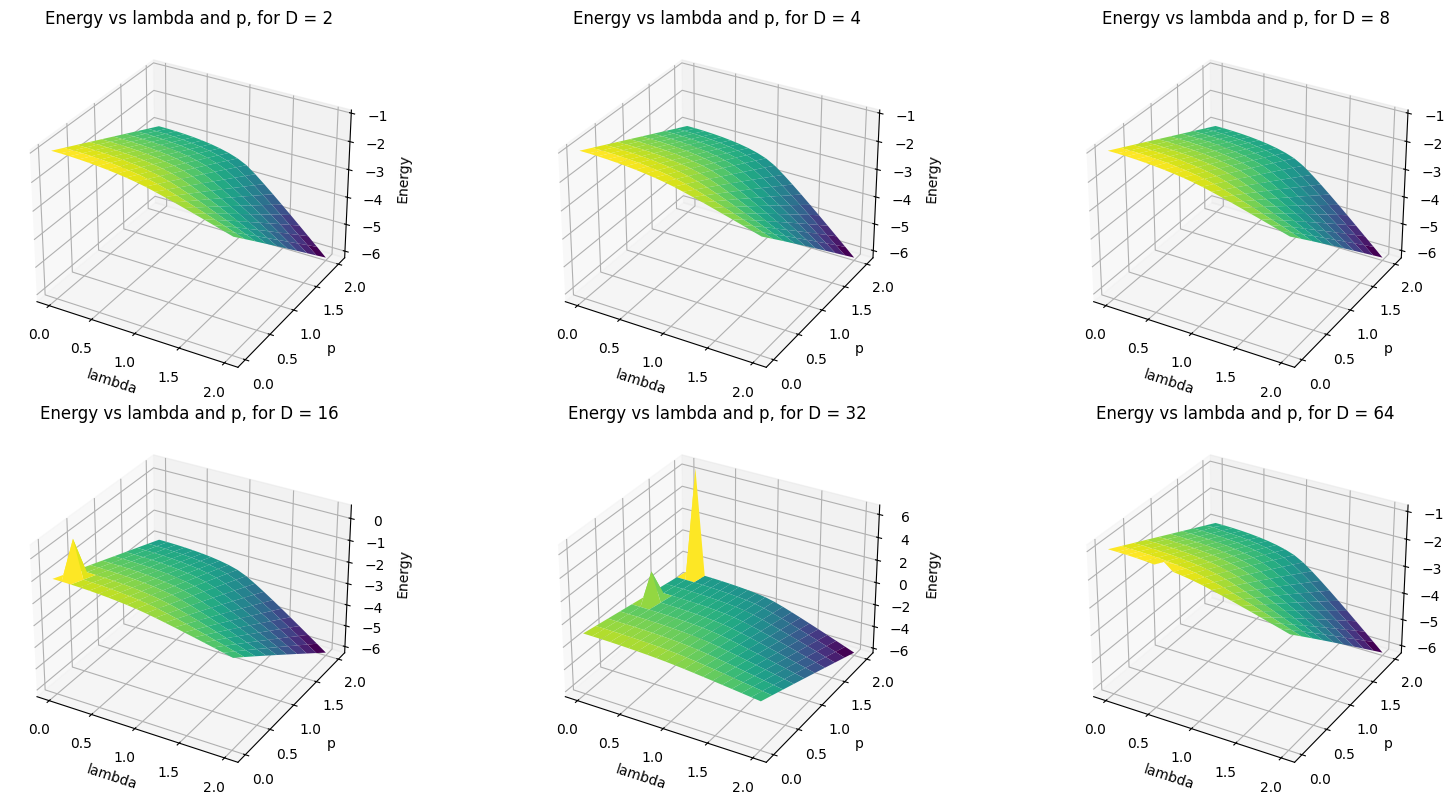

In [ ]:
# Exemple of plotting the results with these sweep interval, using the Sweep Class:
Ds = [2, 4, 8, 16, 32, 64]
p_values = np.linspace(0, 2, 10)
lmbd_values = np.linspace(0.6, 2, 20)
ExtendedIsingModelSweeper.plot_sweep_vs_p_and_lambda(
    results_E3, "Energy", "Energy", Ds, p_values, lmbd_values, "viridis"
)

#### Doing more Zoom around `lambda=1`, with better axis granularity for `D=32, 64`::

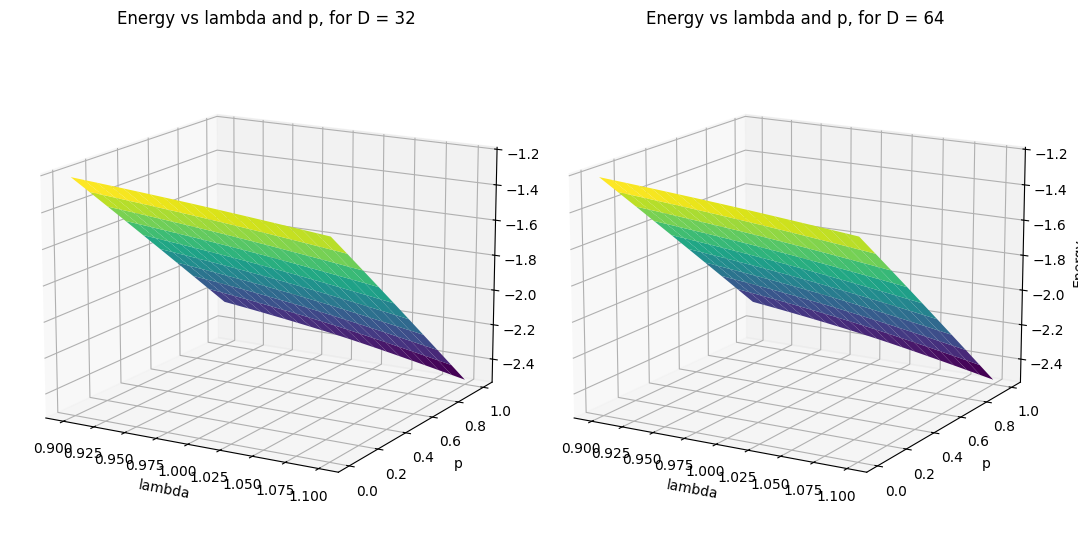

In [ ]:
# Plot results with these sweep intervals:
Ds = [32, 64]
p_values = np.linspace(0, 1, 10)
lmbd_values = np.linspace(0.9, 1.1, 20)
ExtendedIsingModelSweeper.plot_sweep_vs_p_and_lambda(
    results_E4, "Energy", "Energy", Ds, p_values, lmbd_values, "viridis"
)

#### **(b) Compute and plot correlation length $\xi$ vs. $p$ and $\lambda$ for both bond dimensions. Identify regions where $D$ is insufficient to capture the physics.**

#### Same Post-process of results, but this time to vizualize the `correlation lenght` vs `p` and `lambda`
---

#### `P` and `lambda` from 0->2, with `D=2,4,8,16,32,64`:

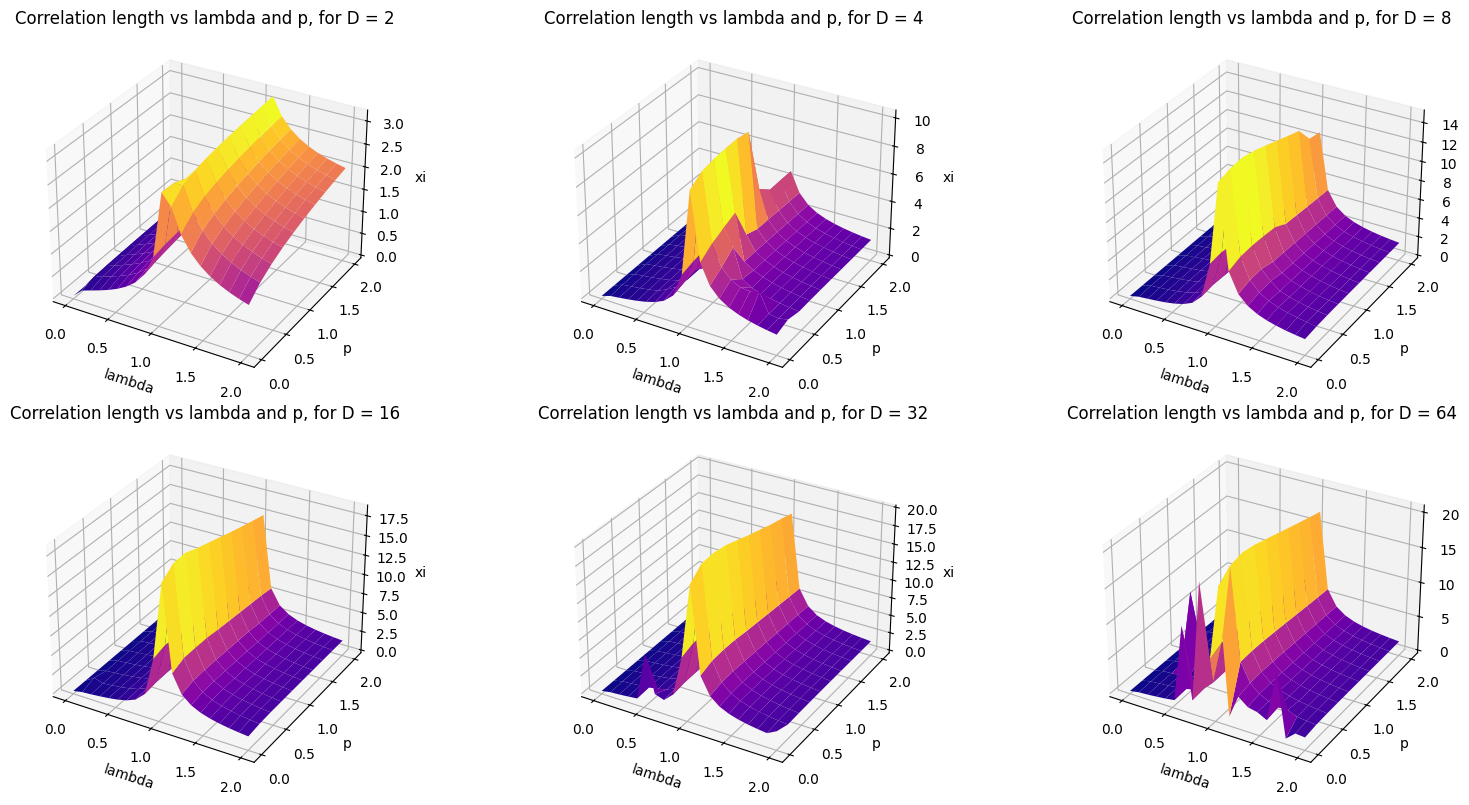

In [362]:
# Plot results with these sweep intervals:
Ds = [2, 4, 8, 16, 32, 64]
p_values = np.linspace(0, 2, 10)
lmbd_values = np.linspace(0, 2, 20)
ExtendedIsingModelSweeper.plot_sweep_vs_p_and_lambda(results_xi8, "Correlation length", "xi", Ds, p_values, lmbd_values)

#### Doing more Zoom around `lambda=1`, with better axis granularity for `D=32, 64`:

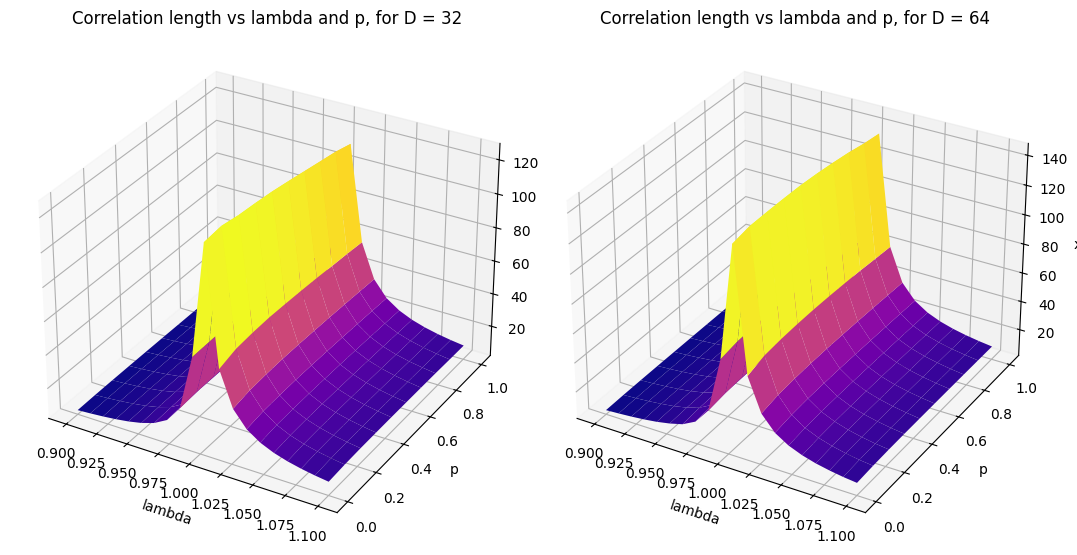

In [267]:
# Plot results with these sweep intervals:
Ds = [32, 64]
p_values = np.linspace(0, 1, 10)
lmbd_values = np.linspace(0.9, 1.1, 20)
ExtendedIsingModelSweeper.plot_sweep_vs_p_and_lambda(results_xi4, "Correlation length", "xi", Ds, p_values, lmbd_values)

#### Where its clear that in the center, `lambda ~ 1`, it keeps growing for bigger D, so smaller D's are not enough around such area.

#### **(c) Using $\xi\propto 1/\Delta$, discuss implications for the phase diagram.**


The relation:

$$\xi \propto \frac{1}{\Delta}$$
​
where $\Delta$ is the energy gap, is a key indicator of the physics. Concretely of two behaviours we can observe in our plots:

- **Gapped Phases:**
When the system is in a gapped phase, $\Delta>>0$. This implies a finite correlation length $\xi$. In these regions, all $D's>16$ should give consistent (and modest) values for $\xi$. From the plots, we can see that this is the case for `lambda`'s far from 1, regions with consistently small and converged $\xi$ for both bond dimensions.

- **Critical or Near-Critical Regions:**
At a quantum phase transition, the gap $\Delta$ closes (or becomes very small), and thus $\xi$ diverges. In practice, the iMPS approximation captures this as a very large correlation length. However, if $\xi$ is very large, a finite bond dimension $D$ imposes a cutoff (an effective finite correlation length due to entanglement truncation). Therefore, in the regions where the simulation results for different $D$'s differ significantly, this is a sign that the true correlation length (and thus the true vanishing gap) is not fully captured by the lower bond dimension. Such is the case of `lambda`'s close to 1 in our plots, areas where $\xi$ grows large and where the estimates are sensitive to $D$.

- **Summary of the Phase Diagram:**  In our model $H$, at `lambda=1` we will have a phase transition where the gap closes (or becomes very small).

### 3. **Extend simulations to larger bound dimensions $D\leq 64$** (1 point):

#### **(a) Identify regions where $\xi$ saturates with $D$ vs where it continues to grow.**

#### Post-process of results to only vizualize the `correlation lenght` vs `lambda` in a fixed `p`:
---

From the symmetry of the plot with `p` in the previous plots, we are only interested on seeing the behaviour vs `lambda`, so we can plot that for several `D`'s and compare:

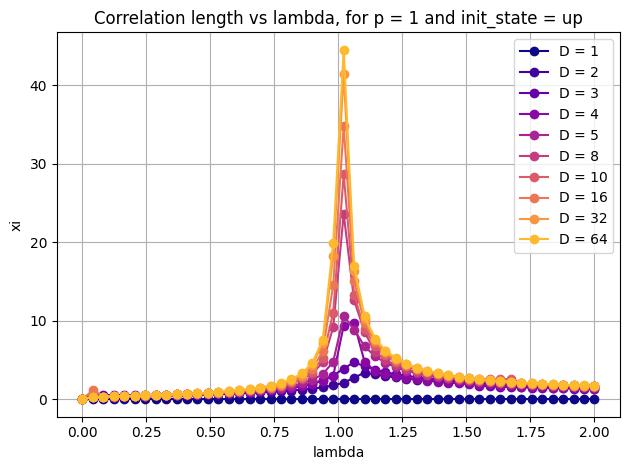

In [354]:
# Execute ploting the cut in p, and only showing dependeance in p, with the Sweep class:
Ds = [1, 2, 3, 4, 5, 8, 10, 16, 32, 64]
p_values = [1]
lmbd_values = np.linspace(0.0, 2.0, 50)

ExtendedIsingModelSweeper.plot_cut_at_fixed_p_vs_lambda(
    results_xi7, "Correlation length", "xi", Ds, p_values[0], lmbd_values, init_state="up"
)

#### We zoom on `lambda=1`, with better granularity of `lambda` and more `D`'s:

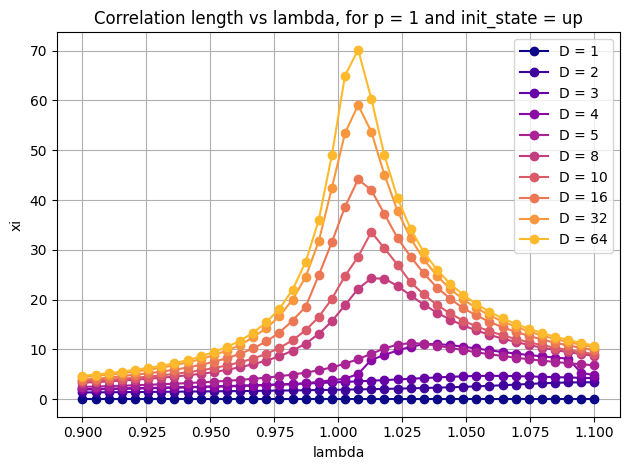

In [366]:
# Plot results with these sweep intervals:
Ds = [1, 2, 3, 4, 5, 8, 10, 16, 32, 64]
p_values = [1]
lmbd_values = np.linspace(0.9, 1.1, 40)

ExtendedIsingModelSweeper.plot_cut_at_fixed_p_vs_lambda(
    results_xi9, "Correlation length", "xi", Ds, p_values[0], lmbd_values, init_state="up"
)

#### From where now its even more clear that for `lambda` close to 1, we need a higher `D`s, since it continues to grow. Instead for `lamda` far from it, the correlation saturates quickly. Meaning that we will have a phase transition for `lambda` $\approx$ `1`.

#### Another interesting point, is seeing how the critical `lambda` depends on `D`, where for smaller `D`'s the critical `lambda` moves to the right, reproducing the result in FIG.3 from [4]:

#### **(b) Plot the half-chain entanglement entropy $S(\xi(D))$ vs $D$ and analyze its behaviour [4].**

#### Same Post-process of results, but this time to vizualize the half-chain entgl. entropy `S` vs `p` and `lambda`:
---

#### `P` and `lambda` from 0->2, with `D=2,4,8,16,32,64`:

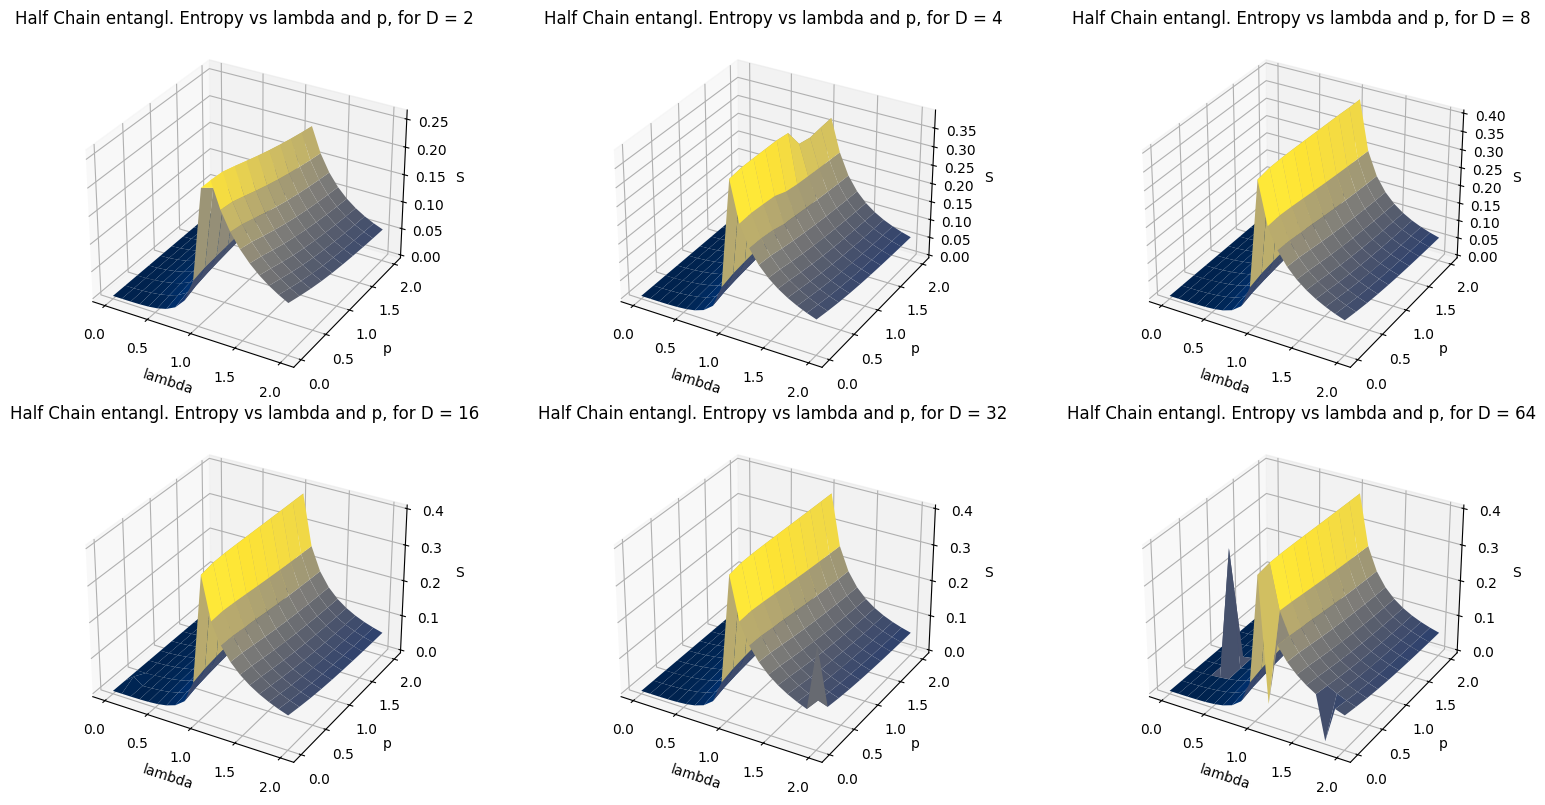

In [385]:
# Plot results with these sweep intervals:
Ds = [2, 4, 8, 16, 32, 64]
p_values = np.linspace(0, 2, 10)
lmbd_values = np.linspace(0, 2, 20)
ExtendedIsingModelSweeper.plot_sweep_vs_p_and_lambda(
    results_S8, "Half Chain entangl. Entropy", "S", Ds, p_values, lmbd_values, "cividis"
)

#### Doing more Zoom on `lambda=1`, with better granularity on the axis:

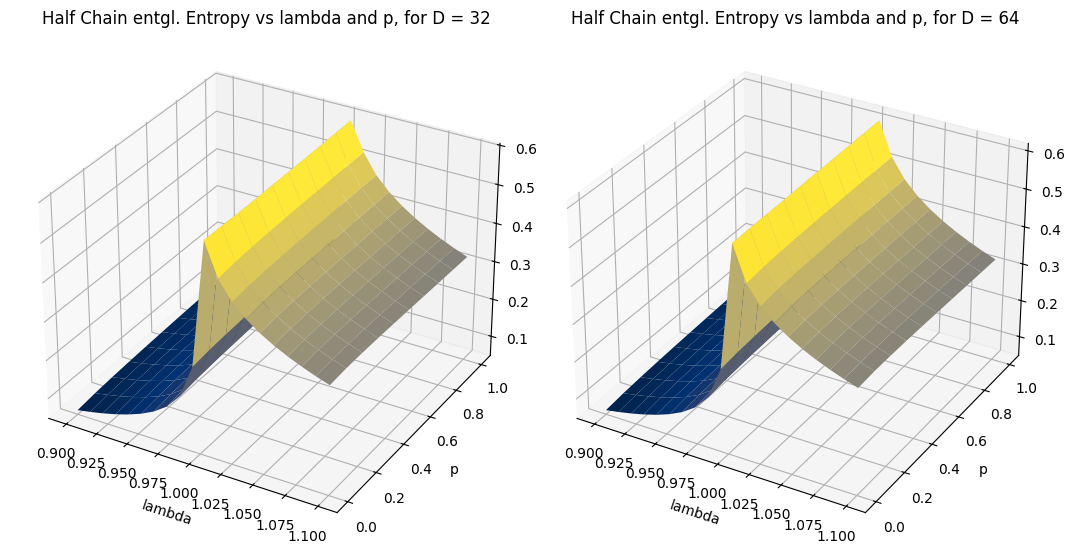

In [257]:
# Plot results with these sweep intervals:
Ds = [32, 64]
p_values = np.linspace(0, 1, 10)
lmbd_values = np.linspace(0.9, 1.1, 20)
ExtendedIsingModelSweeper.plot_sweep_vs_p_and_lambda(
    results_S4, "Half Chain entgl. Entropy", "S", Ds, p_values, lmbd_values, "cividis"
)

#### And now since we also observe a symmetry with respect to `p`, as in the previous 3. (a), we are going to plot cuts, showing only the dependance with `lambda`, for the different `D`'s, to see this behaviour better:

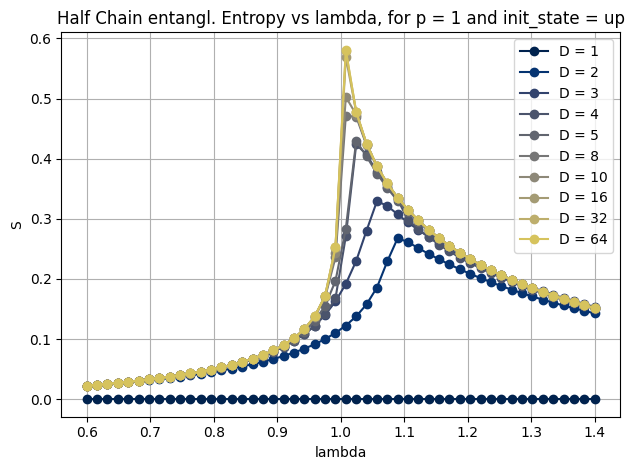

In [324]:
# Plot results with these sweep intervals:
Ds = [1, 2, 3, 4, 5, 8, 10, 16, 32, 64]
p_values = [1]
lmbd_values = np.linspace(0.6, 1.4, 50)
init_state = "up"


ExtendedIsingModelSweeper.plot_cut_at_fixed_p_vs_lambda(
    results_S6, "Half Chain entangl. Entropy", "S", Ds, p_values[0], lmbd_values, init_state, color="cividis"
)

#### Obtaining a very similar result to subfigure (a), from Fig. 2 in [4].

#### And zooming in, for a better granularity of the behaviour vs lambda, looks like:

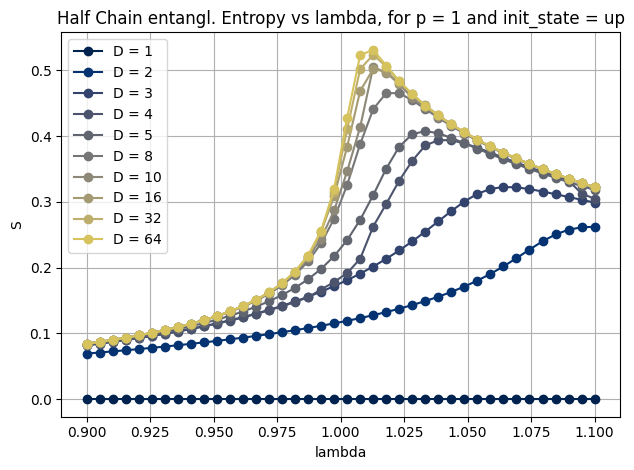

In [367]:
# Plot results with these sweep intervals:
Ds = [1, 2, 3, 4, 5, 8, 10, 16, 32, 64]
p_values = [1]
lmbd_values = np.linspace(0.9, 1.1, 40)


ExtendedIsingModelSweeper.plot_cut_at_fixed_p_vs_lambda(
    results_S9, "Half Chain entangl. Entropy", "S", Ds, p_values[0], lmbd_values, init_state, color="cividis"
)

From [4], we can infere that in critical regions, the finite-entanglement scaling theory predicts that the entanglement entropy is bounded by:
$$S = a + b \log D = c \log \xi + cont, $$
And since the finite bond dimension imposes an effective finite correlation length, one can expect:

- **Gapped Phases:** $S$ will quickly saturate with increasing $D$ because the true ground state has only limited entanglement.

- **Critical Phases:** $S$ will continue to grow (approximately logarithmically) with $D$. More precisely, since the effective $\xi$ grows with $D$ in a critical system, $S$ will also show a logarithmic dependence on $D$.



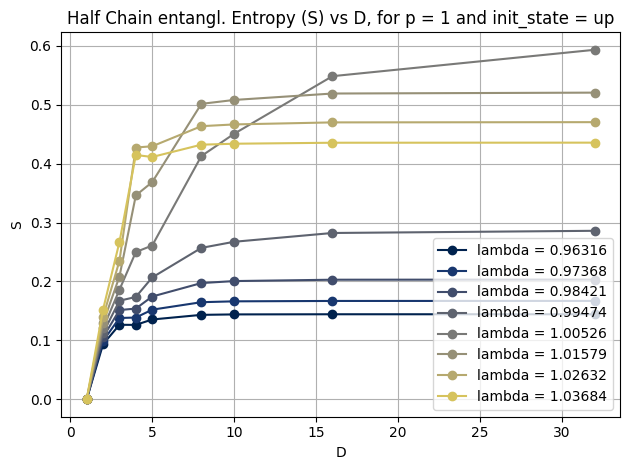

In [388]:
# Plot results with these sweep intervals:
Ds = [1, 2, 3, 4, 5, 8, 10, 16, 32]
p_values = [1]
lmbd_values = np.linspace(0.9, 1.1, 20)[6:-6:1]


ExtendedIsingModelSweeper.plot_vs_D_at_fixed_p_and_lambdas(
    results_S5, "Half Chain entangl. Entropy (S) vs D", "S", Ds, p_values[0], lmbd_values, init_state, color="cividis"
)

#### Where clearly, for the `lambda` closer to 1, we got a logarithmic grow (Critical phase), while the gapped phases saturate faster into a const.

#### So for this case, the one that has not Plateaud (grey higher one), would need a higher `D`, for simulating it correctly.

#### Further thoughts:
---

- In **gapped regions**, both $\xi$ and $S$ tend to saturate as $D$ increases.

- In **critical regions**, you expect to see:

    - $\xi$ increases significantly with $D$, reflecting the divergence of the true correlation length.

    - $S$ grows approximately as $\propto \frac{c}{6} \log \xi $. In practice, plotting $S$ versus $\log\xi$ should yield a straight line whose slope gives an estimate of the central charge $c$.

    - When you plot $S$ vs. $D$ if $S$ continues to increase (rather than plateauing), it is an indication that the bond dimension is still limiting the amount of entanglement captured and that the system is near a critical point.

#### This can also seen in this other plot, where we check the Correlation lenght `Xi` as a function of `D`, where for the critical `lambda`, should keep increasing for bigger `D`'s, while for the rest, should get bounded into a plato, since no more entanglement is needed:

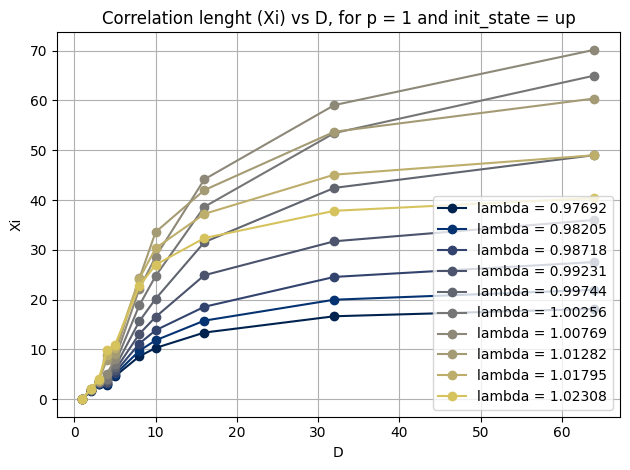

In [392]:
# # Plot results with these sweep intervals:
Ds = [1, 2, 3, 4, 5, 8, 10, 16, 32, 64]
p_values = [1]
lmbd_values = np.linspace(0.9, 1.1, 40)[15:-15:1]


ExtendedIsingModelSweeper.plot_vs_D_at_fixed_p_and_lambdas(
    results_xi9, "Correlation lenght (Xi) vs D", "Xi", Ds, p_values[0], lmbd_values, init_state, color="cividis"
)

#### where we can see how they all start similar to an exponential, since from FIG. 5 in [4] we expect $\xi \propto a D^k$. But as `D` increases then they start getting bounded, concretely the closer `lambda` is to the critical `lambda`, the later the bound starts (needing a higher correlation in the end).

---
---
---

## **III. Out-of-Equilibrium Dynamics (5 points)**
#### **Implement the quantum quench protocol using $TeMPy$**:


### 1. **Quench from a product state using (~~the iTEBD~~) an MPO time evolution algorithm**:

#### **(a) Initialize all spins in $|+\rangle$ state (along x-axis)**.


In [ ]:
model_params = {"L": 10, "S": 0.5, "p": 0.5, "lmbd": 1.0, "bc_MPS": "infinite", "conserve": None}
model = ExtendedIsingModel(model_params)

# Get an initial ansatz for the model:
state = model.get_plus_ansatz(init_state)


#### **(b) Evolve under the Hamiltonian $H$ with $p=0.5$ and $\lambda=1$ for time $t=5$, using a maximum bond dimension $D=100$.**


2. **Plot the following as functions of time** (0.5 pts each):
    
    (a) Magnetization $\langle\sigma^{x}\rangle(t)$

    (b) Magnetization $\langle\sigma^{z}\rangle(t)$

    (c) Explain the behaviour of $\langle\sigma^{z}\rangle$ using algebraic reasoning.

    (d) Entanglement entropy of half-chain

    (e) Bond dimension $D$

    (f) Truncation error $\epsilon$.

    (g) Discuss the relation between bond dimension growth, truncation error, and entanglement entropy

3. **Entanglement spectrum analysis** (1 point):

    (a) Compute the entanglement spectrum $e_{i}=-\log(\lambda_{i})$ where $\lambda_i$ are the eigenvalues of the reduced density matrix.
    
    (b) Define gaps $\Delta_{i}=e_{i}-e_{0}$ for the $10$ largest eigenvalues and plot both $\Delta_{i}$ and their ratios $\Delta_{i}/\Delta_{1}$ as functions of time.

4. **Discussion** (0.5 points): Summarize and interpret results [5].

## **IV. Summary**
This assignment aims to deepen your understanding of quantum phase transitions and non-equilibrium dynamics using tensor network methods. Key takeaways include:

- Identifying quantum phases via correlation length scaling.

- Observing entanglement growth in quench dynamics.
    
- Understanding computational limitations imposed by bond dimension and truncation errors


## References:

[1] F. C. Alcaraz, Phys. Rev. B **94**, 115116 (2016).

[2] J. Hauschild and F. Pollmann, SciPost Phys. Lect. Notes 005 (2018).

[3] J. Hauschild et al., $arXiv:2408.02010$ (2024).

[4] L. Tagliacozzo et al., Phys. Rev. B **78**, 024410 (2008).

[5] J. Surace et al., Phys. Rev. B **101**, 241107 (2020).
